# Overview
This is my first attempt to solve the African Inclusion data science competition on the [Zindi](https://zindi.africa/) data science platform. Please find the [link](https://zindi.africa/competitions/financial-inclusion-in-africa) to the competition 

# Preliminary: Imports and Loading Data

In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [224]:
# variable to determine whether the notebook is running on Collab or not
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

The data is not visible in the github directory as it is prohibited by the competition's rules. After downloading the data from the site, please make sure to have it in the same directory as the notebook.

In [225]:
import os
from zipfile import ZipFile

DOWNLOAD_DIR = "sample_data" if IN_COLAB else os.getcwd() 
file_name = "financial-inclusion-in-africa.zip"
file_name_no_zip = "financial_inclusion_in_africa"
loc = os.path.join(DOWNLOAD_DIR, file_name)
# opening the zip file in READ mode

if not os.path.isdir(os.path.join(DOWNLOAD_DIR, file_name_no_zip)):
    with ZipFile(loc, 'r') as zip_ref:
        zip_ref.extractall()
        print('Done!')

Done!


In [226]:
train_loc = os.path.join(os.getcwd(), "Train.csv")
test_loc = os.path.join(os.getcwd(), "Test.csv")

df = pd.read_csv(train_loc)
df_test = pd.read_csv(test_loc)


In [227]:
initial_df = df.copy()
initial_df_test = df_test.copy()


# Helper functions
In this section, I define a number of functions I will frequently use across the notebook.

In [228]:
# a function to delete columns from both the train and test datasets
def drop_cols(cols, df_train: pd.DataFrame, df_test: pd.DataFrame):
    if isinstance(cols, str):
        df1 = df_train.drop(cols, axis=1)
        df2 = df_test.drop(cols, axis=1)
    else:
        df1 = df_train.drop(columns=cols)
        df2 = df_test.drop(columns=cols)
    return df1, df2

In [229]:
def new_col_names(old_new_names, df_train ,df_test):
    try:    
        df = df_train.rename(columns=old_new_names)
        df_test = df_test.rename(columns=old_new_names)
        return df, df_test
    except:
        df_no_col = [col for col in old_new_names.keys if col not in df.columns]
        df_test_no_col = [col for col in old_new_names.keys if col not in df_test.columns]
        print("{cols} are not in the {dataf}".format(df_no_col, "training dataset"))
        print("{cols} are not in the {dataf}".format(df_test_no_col, "test dataset"))


In [230]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoder(df: pd.DataFrame, features_names: list=None):
    # select all categorical features if none of them were specified
    if features_names is None:
        features_names = df.select_dtypes(include=['object']).columns.tolist()
    # define the encoder
    
    ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False, dtype=np.int64)
    for f in features_names:        
        try:
            unique_values = np.unique(df[f])
        except:
            unique_values = list(df[f].value_counts().index)
        
        # if there is only one unique value in the column, then this column is to be dropped
        if len(unique_values) <= 1 :
            break
        # the names for the  newly-created features
        new_names = [f'{f}_{u}' for u in unique_values[1:]]
        new_values = ohe.fit_transform(df[[f]])
        print(ohe.categories_)
        df[new_names] = new_values
    
    return df


In [231]:
! pip install empiricaldist
# empiricaldist is quite a powerful library for statistical data analysis


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [232]:
# let' define a function that applies a function to either 
# the whole dataframe or certain columns on the dataframe

def apply_functions(df_train, df_val, funcs, col_names=None):
    # either have one function passed that should be applied to the whole dataframe
    # or have an equal number of columns and functions where each funtion will be applied to the corresponding column
    all_data = callable(funcs) and col_names is None
    col_funcs = True
    #  if the funcs argument is indeed a function, then the code below will raise an error 
    try:
        col_funcs = (all([callable(f) for f in funcs]) and len(funcs) == len(col_names))
    except:
        col_funcs = False
    
    assert all_data or col_funcs
        
    if col_names is None: # if the function is to be applied on the whole dataframe
        df = df_train.apply(funcs, axis=1)
        df_test = df_val.apply(funcs, axis=1)
    else:
        df = df_train.copy()
        df_test = df_val.copy()

        for col, f in zip(col_names, funcs):
            df[col] = df[col].apply(f)
            df_test[col] = df_test[col].apply(f)
            
    return df, df_test

In [233]:
def get_col_types(df: pd.DataFrame, nunique_as_discrete=20):
    # select all numerical features 
    num_cols = set(list(df.select_dtypes(np.number).columns))
    # any feature that is non-numerical is selected as categorical
    cat_cols = set([c for c in df.columns if c not in num_cols])
    
    # let's further filter the numerical features: those with a small number of unique values are considered categorical
    discrete_num_cols = [col for col in num_cols if len(df.value_counts(col)) <= nunique_as_discrete]
    # add them to the categorical features
    cat_cols.update(discrete_num_cols)
    # update the numerical features
    num_cols = num_cols.difference(cat_cols)
    return num_cols, cat_cols



In [234]:
from empiricaldist import Cdf

def display_cdfs(data:pd.DataFrame, y:str, feat:str, feat_values:list=None):
   
    # if the values of the feature are not determined, then we consider all values
    if feat_values is None: 
        feat_values = list(df[feat].value_counts().index)
    
    # construct the conditional cdf of the target 'y' for each unique passed value of 'feat' 
    for v in feat_values:
        d = data[data[feat] == v][y]
        data_cdf = Cdf.from_seq(d)
        data_cdf.plot(label=v)

    plt.legend()
    plt.xlabel(f'{y}')
    plt.ylabel(f'cdf of {feat}')
    plt.show()   


In [235]:
def display_histogram(data, num_feat, cat_feat, figsize=None):
    if figsize is None:
        figsize = (10, 10)
    plt.figure(figsize=figsize)
    cat_unique = list(data.value_counts(cat_feat).index)
    for v in cat_unique:
        plt.hist(data[data[cat_feat] == v][num_feat], bins=100, alpha=0.5, label=f"{cat_feat} == {v}")

    plt.xlabel(f"{num_feat}", size=14)
    plt.ylabel("count", size=14)
    plt.title(f"{num_feat} distribution for different values of {cat_feat}")
    plt.legend(loc='upper right')
    plt.show()

def display_cat_plot(data: pd.DataFrame, num_feat, cat_feat, num_cat='box'):
    g = sns.catplot(data=data, x=num_feat, y=cat_feat, kind=num_cat, orient='h')
    g.fig.suptitle(f"distribution of {num_feat} for different values of {cat_feat}")
    g.set(xlabel=f"{num_feat}", ylabel=f"{cat_feat}")
    plt.show()

def visualize_num_cat(data: pd.DataFrame, num_feat: str, cat_feat: str, num_cat='box', nunique_as_discrete=20):
        valid_num_cat = ['cdf', 'hist', 'box', 'violin','boxen']
        num_cat = num_cat.lower()
        
        # make sure to have a meaningful plot
        if num_feat == cat_feat or len(data.value_counts(cat_feat)) > nunique_as_discrete: 
            return
        try:
            assert num_cat in valid_num_cat
            # only display categorical features with reasonable number of categories / unique values
            if num_cat == 'cdf':
                display_cdfs(data, y=num_feat, feat=cat_feat)
            elif num_cat == 'hist':
                display_histogram(data, num_feat=num_feat, cat_feat=cat_feat)
            else:
                display_cat_plot(data=data, num_feat=num_feat, cat_feat=cat_feat, num_cat=num_cat)
        except (KeyError, AssertionError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID num_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {valid_num_cat}")    

def visualize_cat_cat(data: pd.DataFrame, cat1: str, cat2: str, nunique_as_discrete=20, cat_cat='count', hist_stats='percent'):
        # make sure to have a meaningful plot
        if cat1 == cat2 or len(data.value_counts(cat1)) > nunique_as_discrete or len(data.value_counts(cat2)) > nunique_as_discrete: 
            return
        
        # the hue parameter should be assigned the feature with the smaller number of possible values
        feats = [cat1, cat2]
        feats = sorted(feats, key=lambda x: len(data.value_counts(x)))
        hue_feat, x_feat = feats
        try:            
            if cat_cat == 'hist':
                sns.histplot(data=data, x=x_feat, hue=hue_feat, stat=hist_stats)
            else:
                sns.catplot(kind=cat_cat, data=data, x=x_feat, hue=hue_feat)                
            plt.xticks(rotation=45)
            plt.show()
        except (AssertionError, KeyError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID cat_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {['count', 'bar', 'hist']}")    
        
def visualize_num_num(data: pd.DataFrame, num1: str, num2: str, num_num='scatter'):
        # make sure to have a meaningful plot
        if num1 == num2: 
            return
        
        try:
            g = sns.relplot(data=data, x=num1, y=num2, kind=num_num)
            g.fig.suptitle(f"The bivaritate distribution of {num1} and {num2}")
            g.set(xlabel=f"{num1}", ylabel=f"{num2}")
            plt.legend('best')
            plt.show()
        except (AssertionError, KeyError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID cat_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {['scatter']}")    


In [236]:

def visualize_interaction(data:pd.DataFrame, feature, use_cols=None, nunique_as_discrete=20, num_cat='box', num_num='scatter', cat_cat='count', num_feats=None, cat_feats=None
, hist_stats='percent'):
    try:
        data[feature]
    except (KeyError):
        print(f"{feature} is not part of the dataframe's features")
        return 

    if use_cols is None:
        use_cols = data.columns

    if isinstance(use_cols, str):
        use_cols = [use_cols] 

    # filter the use_cols to keep only those belonging to the passed dataframe
    use_cols = [column for column in use_cols if column in set(data.columns)]

    if num_feats is None or cat_feats is None:
        # extract the numerical and categorical features, if they are not specified by the user-call
        num_feats, cat_feats = get_col_types(data)

    # consider the case where the passed feat is indeed categorical:
    if feature in cat_feats:
        # iterate through all the columns in the dataset
        for col in use_cols:
            if col in num_feats: 
                visualize_num_cat(data=data, num_feat=col, cat_feat=feature, num_cat=num_cat, nunique_as_discrete=nunique_as_discrete)
            elif col in cat_feats:
                visualize_cat_cat(data=data, cat1=col, cat2=feature, cat_cat=cat_cat, nunique_as_discrete=nunique_as_discrete, hist_stats=hist_stats)
    
    elif feature in num_feats:
        for col in use_cols:
            if col in num_feats:
                visualize_num_num(data=data, num1=col, num2=feature)
            elif col in cat_feats:
                visualize_num_cat(data=data, num_feat=feature, cat_feat=col, num_cat=num_cat, nunique_as_discrete=nunique_as_discrete)    
    

In [237]:
# even though the previous visualization options are quite helpful, sometimes the data analysis purposes require a bit more detailed and statistics-oriented results
# assuming we have a target varaible y and an explantory variable 'x': (categorical)  

def visualize_cond_prob(data: pd.DataFrame, target:str, hue:str, nunique_as_discrete=20):
    try:
        c1 = data[hue] 
        c2 = data[target]    
    except KeyError:
        print(f"PLEASE MAKE SURE BOTH {hue} and {target} ARE COLUMNS OF THE PASSED DATAFRAME")
        return

    if hue == target or len(data[hue].value_counts()) > nunique_as_discrete:
        print("Please make sure to input two different categorical columns")
        return

    # first extract the unique values of each of the passed columns
    target_values = data[target].value_counts().index
    hue_values = data[hue].value_counts().index
    

    # define the resulting dataframe shape
    result = pd.DataFrame(data=[], index=target_values, columns=hue_values)

    for h in hue_values:
        # the number of rows for which the column hue has the value 'h'
        h_count = len(data[data[hue] == h])
        result[h] = data[data[hue] == h][target].value_counts() / h_count

    # counting for the following possibility: certain combination of value of hue and target do not appear in the result
    result.fillna(value=0, inplace=True)

    # visualize the result by creating a heatmap
    g = sns.heatmap(result, annot=True, linewidth=0.5, linecolor='b', cmap=sns.color_palette("rocket_r", as_cmap=True))
    # let's add labels to the axis
    plt.xlabel(f'values of the column {hue}')
    plt.ylabel(f'conditional probabilities {target} on {hue}')
    plt.title(f'condition distribution of {target} on {hue}')
    plt.show()


In [238]:
def map_values(df:pd.DataFrame, df_test:pd.DataFrame, columns:list , cols_dicts:dict):
    """ This function will map certain values in each passed to another set of values. The mapping is defined by the cols_dicts
    """
    # first make sure all columns are part of the dataframe
    try:
        df.loc[:, columns] 
    except KeyError:
        print(f"PLEASE MAKE SURE THAT each column in {list(columns)} belongs to the passed dataframe")
    
    # make sure passing a string is acceptable
    if isinstance(columns, str):
        columns = [columns]
    
    # make sure passing a single dictionary is acceptable
    if isinstance(cols_dicts, dict):
        cols_dicts = [cols_dicts]

    # second make sure the lengths of both iterables are the same
    assert len(columns) == len(cols_dicts)

    # map the dictionary and the columns into a single dictionary
    replace_dictionary = dict(zip(columns, cols_dicts))
    # return the new dictionary
    return df.replace(to_replace=replace_dictionary), df_test.replace(to_replace=replace_dictionary)


In [275]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='f1'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [282]:
def create_submission(estimator, X_train, y, X_test, estimator_name):
    estimator.fit(X_train, y)
    y_pred = estimator.predict(X_test)
    submission = pd.DataFrame({"uniqueid": initial_df_test["uniqueid"] + " x " + initial_df_test["country"],
                            "bank_account": y_pred}).set_index('uniqueid')
    
    submission.to_csv(os.path.join(os.getcwd(), f"{estimator_name} submission.csv")) 
    return submission

I have previously created a python script with a number of helper functions to evaluate and select models. The cell below will download the script to the local directory

In [241]:
# for linux
! wget https://raw.githubusercontent.com/ayhem18/My_Kaggle_Repo/space_titanic/Competitions/SpaceshipTitanic/classifiers.py

# for windows
! curl.exe -o classifiers.py https://raw.githubusercontent.com/ayhem18/My_Kaggle_Repo/space_titanic/Competitions/SpaceshipTitanic/classifiers.py

'wget' is not recognized as an internal or external command,
operable program or batch file.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3806  100  3806    0     0  15130      0 --:--:-- --:--:-- --:--:-- 15285


# MVP
In this section, I will build a minimalistic end to end pipeline to evaluate the baseline performance and then iterate through it for better performance.

## First "feel" of the Data

In [242]:
# let's get more familiar with our data
df.head()
# as we can see most of the data is categorical
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


* The good news is that we won't have to deal with null values
* the majority of columns are categorical: The only really continous column is age
* let's change the column names shall we ?

In [243]:
# first let's change the columns' names for easier manipulation
# according to the starter notebook, the target variable is uniqueid

new_names = {"uniqueid": "id", 'bank_account': "y", 'location_type':'loc', 'cellphone_access': 'phone', 'household_size': 'h_size','age_of_respondent': 'age', 
'gender_of_respondent':'gender', 'relationship_with_head': 'fam_role', 'marital_status':'status', 'education_level' : 'edu', 'job_type': 'job'}

# let's change the names in both datasets

df, df_test = new_col_names(new_names, df, df_test)

# having a copy of the original datasets for further use
df_train_org = df.copy()
df_test_org = df_test.copy()

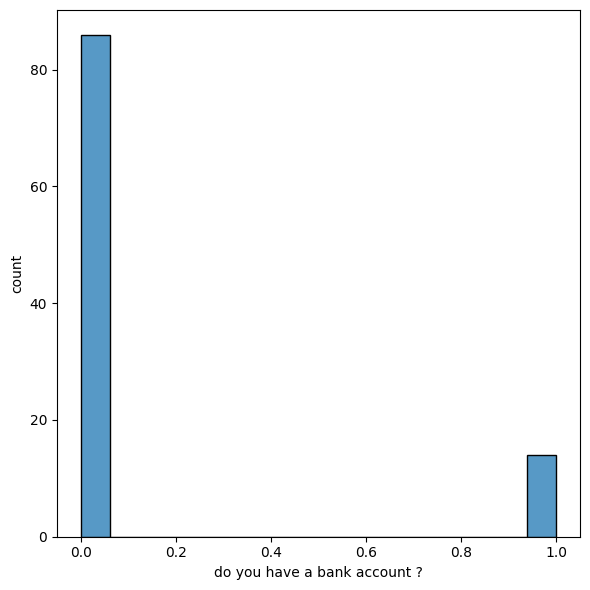

In [244]:
# let's first proceed to convert the target variable to a numerical type
df['y'] = df['y'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

# let's take a quick look on the distribution of our target variable
sns.histplot(data=df, x='y', stat='percent')
plt.xlabel('do you have a bank account ?')
plt.ylabel('count')
plt.show()
# as we can see, we are dealing with a significantly unbalanced dataset with only less than 20% of the samples belonging to the positive class

In [245]:
# before proceeding with a better EDA, let's first remove the id column from both datasets as it is not informative
df, df_test = drop_cols(['id'], df, df_test)

In [246]:
num_cols, cat_cols = get_col_types(df, nunique_as_discrete=25)
print(num_cols)
print(cat_cols)

{'age'}
{'fam_role', 'gender', 'loc', 'phone', 'status', 'country', 'edu', 'job', 'y', 'year', 'h_size'}


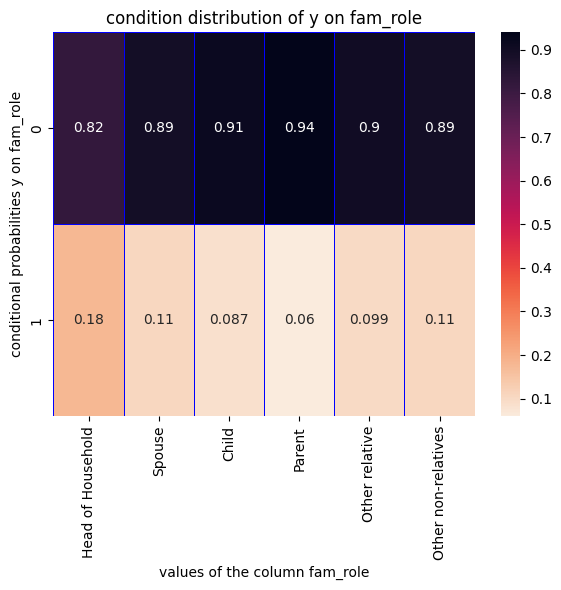

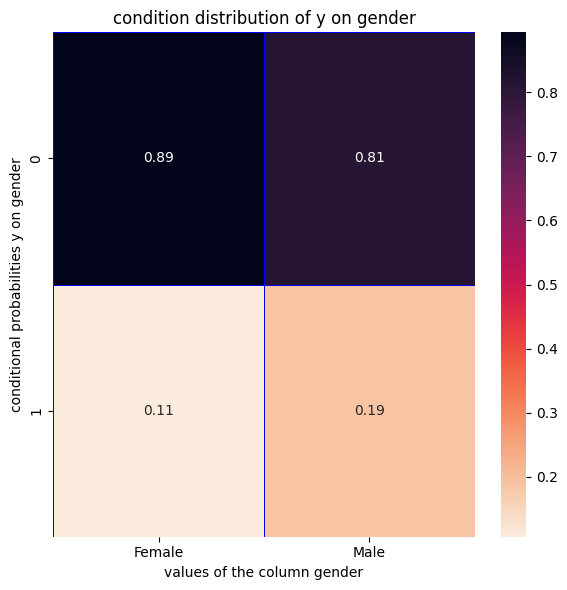

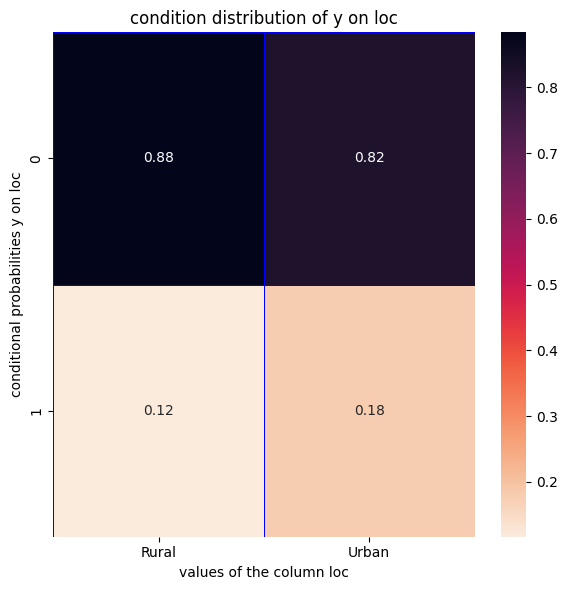

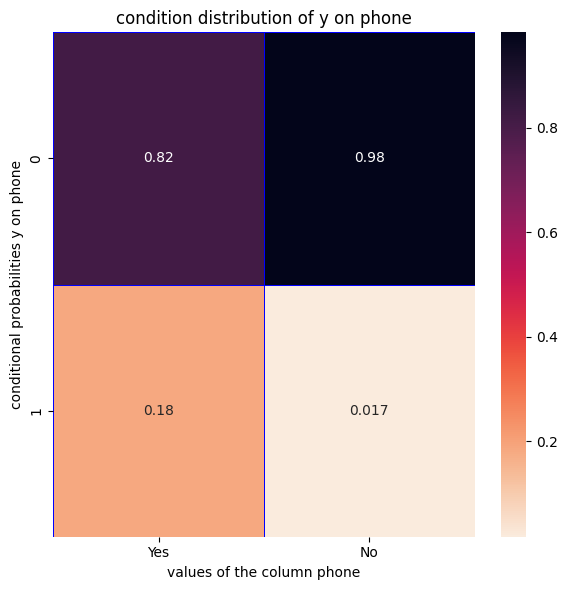

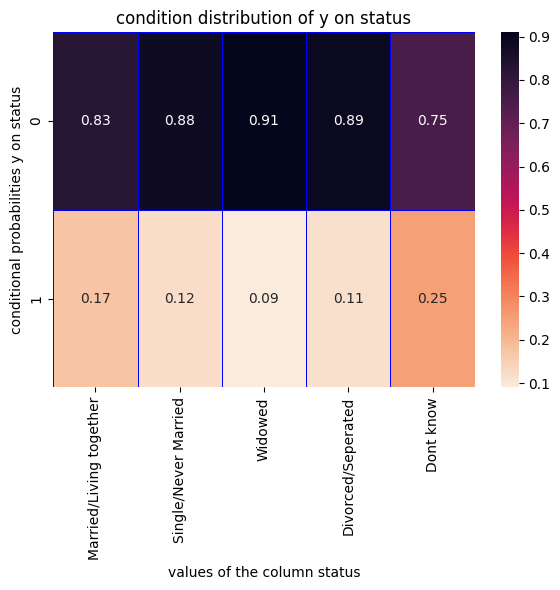

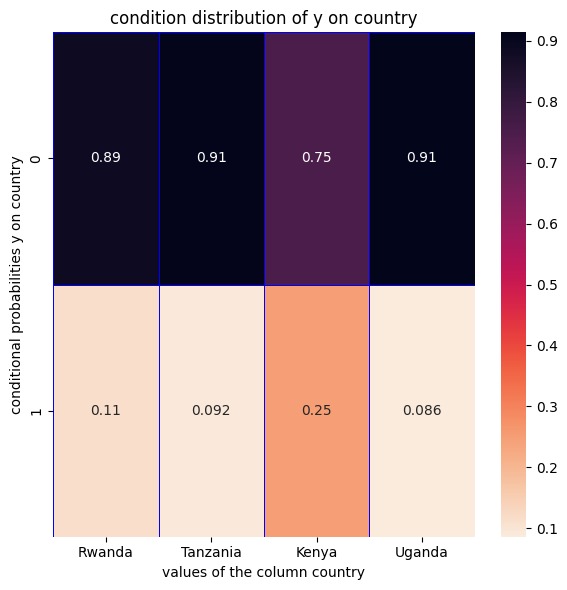

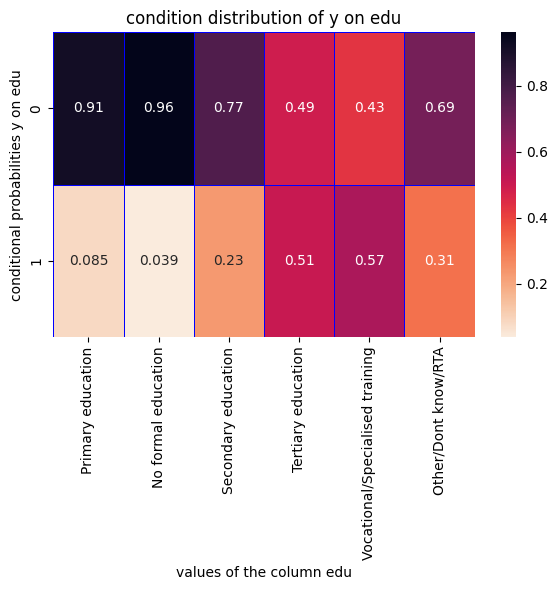

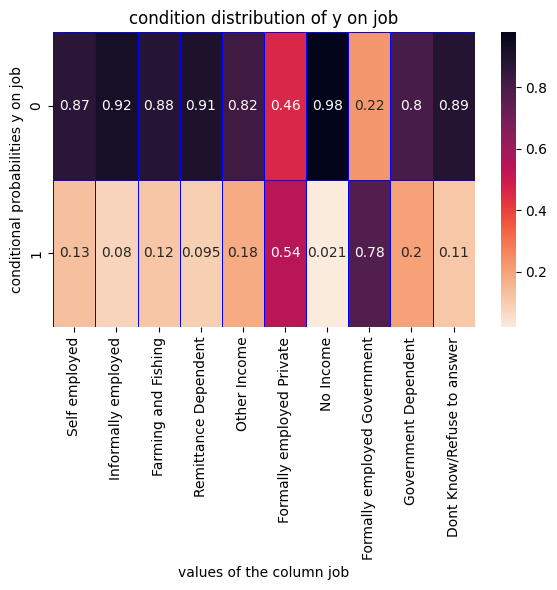

Please make sure to input two different categorical columns


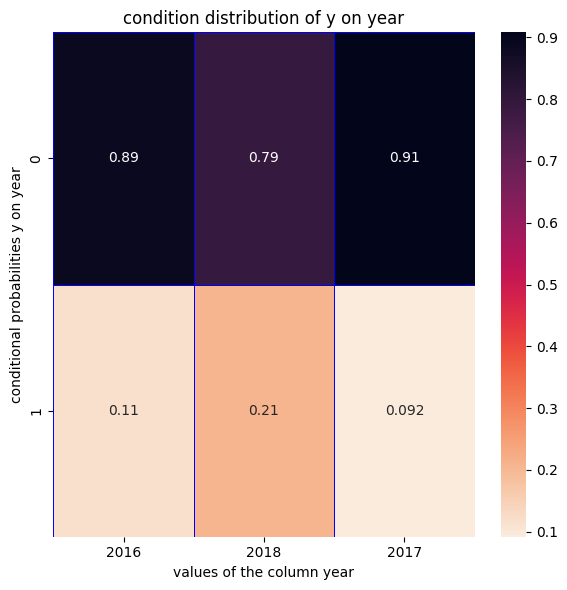

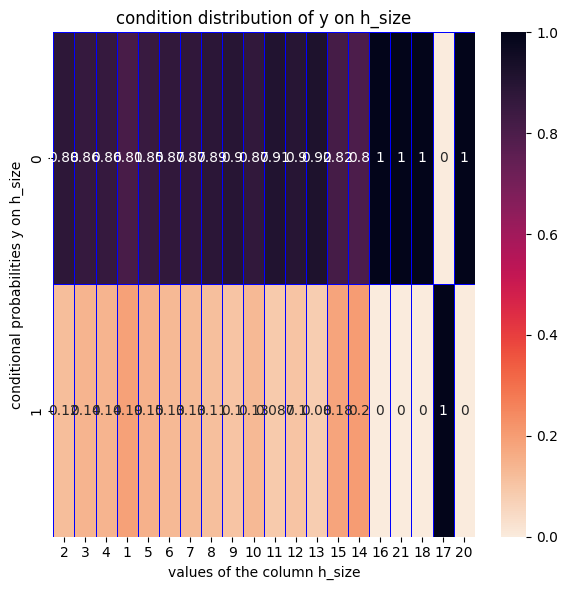

In [247]:
# as indicated earlier the majority of the data is categorical which calls for a lot of data cleaning
# let's focus on these at the moment

for c in cat_cols:
    visualize_cond_prob(data=df, target='y', hue=c)


Time for some observations:
1. Married and Don't know status are the most interesting. The Don't know value is a bit intriguing (it should be investigated)
2. The education level is quite a good indicator: The value of Other\Don't know should be investigated
3. Kenya is significantly more developed in the banking sector. the first approach is to convert the country column to a binary column: is_Kenya
4. The family role column at first glance is not so informative 
5. more work should be done on the size of the household 
6. The job column is quite informative: certain columns should be grouped together. The Don't know value is (again!!!) intriguing 
7. the **phone** column is a quite informative. Even though the conditional probability 
$
\begin{align} P(Y = 1 |~phone = yes) = 0.18 
\end{align} 
$ 
the probability $(phone = yes| Y = 1 )$ is above $0.9$
8. Even though males seems to be more likely to have a bank account, it is far away from being conclusive
9. The probability distribution of the ***year*** column seems interesting. Nevertheless, it seems from the data that the 'year' column is determined by the country column. to be validated
10. for the initial model, this column does not seem informative enough.  

In [248]:
# let's verify the assumption of the 8th point
print(pd.pivot_table(df, index='country', values='year', aggfunc=['min', 'max']))
# the max and min value for each country is the same, thus the year is useless for our analysis.
df, df_test = drop_cols(['year'], df, df_test)

           min   max
          year  year
country             
Kenya     2018  2018
Rwanda    2016  2016
Tanzania  2017  2017
Uganda    2018  2018


## Gender, Status, and family role

In [249]:
# let's consider the status column
print(df['status'].value_counts())
# as expected, an unsignificant number of rows answered with Don't know
# let's see if those people are the same as the ones answering Don't know for the education level
print(df['edu'].value_counts())
print(df['job'].value_counts())

Married/Living together    10749
Single/Never Married        7983
Widowed                     2708
Divorced/Seperated          2076
Dont know                      8
Name: status, dtype: int64
Primary education                  12791
No formal education                 4515
Secondary education                 4223
Tertiary education                  1157
Vocational/Specialised training      803
Other/Dont know/RTA                   35
Name: edu, dtype: int64
Self employed                   6437
Informally employed             5597
Farming and Fishing             5441
Remittance Dependent            2527
Other Income                    1080
Formally employed Private       1055
No Income                        627
Formally employed Government     387
Government Dependent             247
Dont Know/Refuse to answer       126
Name: job, dtype: int64


According to the distribution, the following are reasonable assumptions (at least for a baseline performance)  
1. In the ***status*** column, "Don't know" can be mapped to  Single/Never Married
2. In the ***edu*** column, "Other" can be mapped to 'No formal Education'
3. In the ***job*** column, "Dont know" can be mapped to 'No Income' 
 

In [250]:
job_dict = {"Dont Know/Refuse to answer": "No Income"}
edu_dict = {"Other/Dont know/RTA": "No formal education"}
status_dict = {"Dont know": "Single/Never Married"}

df, df_test = map_values(df, df_test, columns=['job', 'edu', 'status'], cols_dicts=[job_dict, edu_dict, status_dict])

Before proceeding with grouping values in different columns, let's have a better look on the interactions between the following sets of columns
1. status and fam_role, gender and fam_role
3. edu, job, and fam_role
4. country and loc

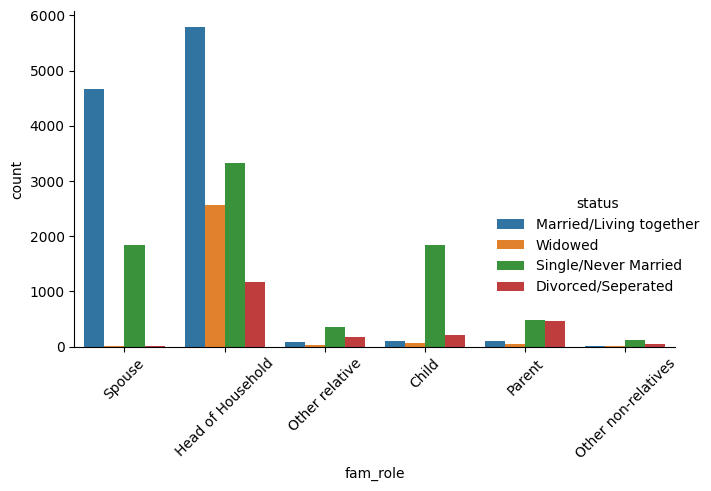

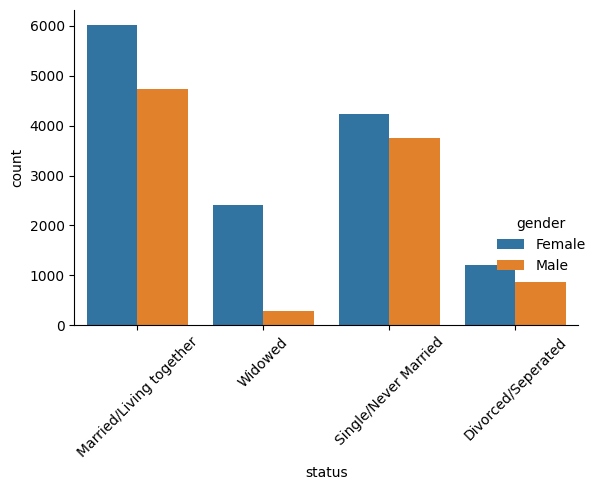

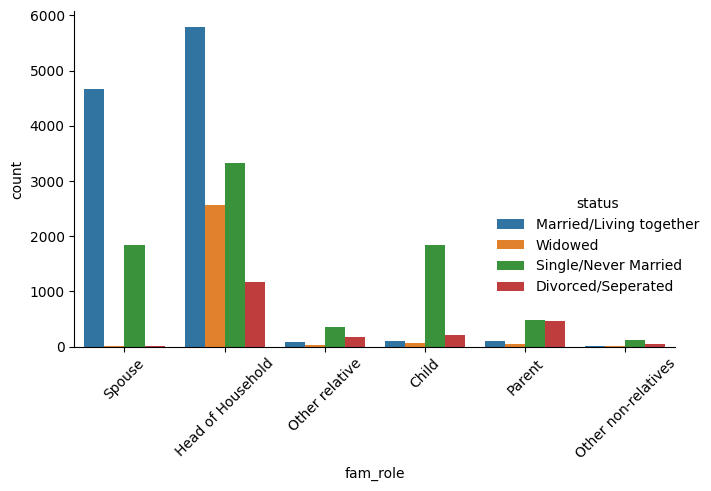

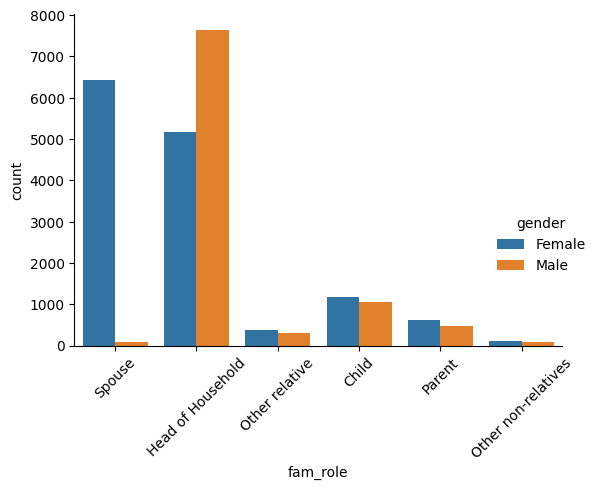

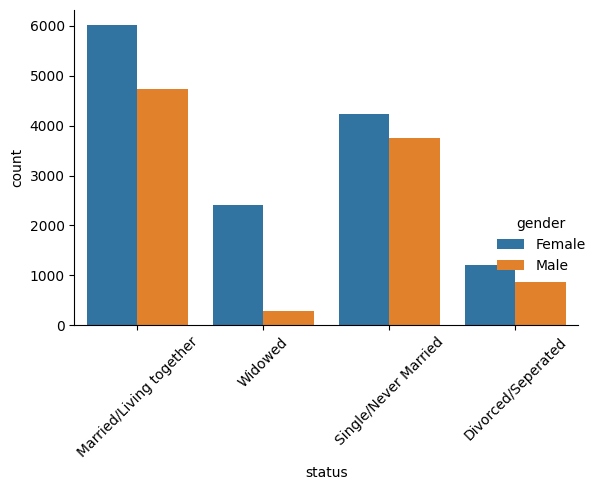

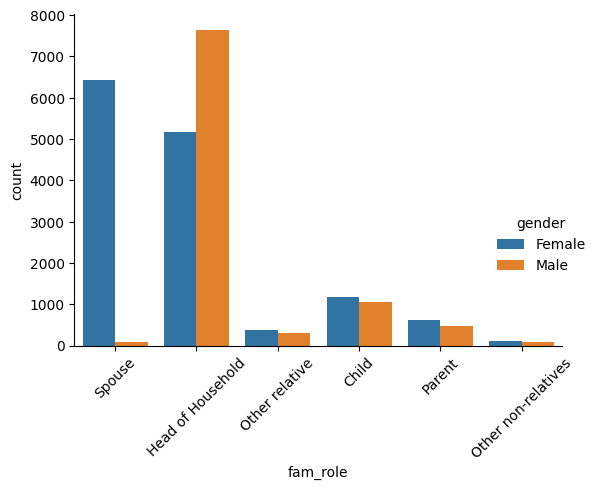

In [251]:
# the 1st set
cols_1 = ['status', 'fam_role', 'gender']
for c in cols_1:
    visualize_interaction(df, c, use_cols=cols_1)

* possible conclusions from the gender, fam_role and gender interactions:
1. if the individual is either Head of Household then they are either Non-married or a child, married and Male. In other words, 
2. The non-married should be somehow linked to the house size


In [252]:
# let's intoduce the mosaid plot to better understand the interaction
# to do that we will use the statsmodels library
! pip install statsmodels


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [253]:
print(df['status'].value_counts())

Married/Living together    10749
Single/Never Married        7991
Widowed                     2708
Divorced/Seperated          2076
Name: status, dtype: int64


In [254]:
# let's use it on the first set of columns 
# let;s reduce the number of values for the fam_role column
fam_role_map = {"Parent": 'ex_fam', 'Other relative': 'ex_fam', 'Other non-relatives': 'ex_fam', 'Head of Household': 'head', 'Spouse': 'sp', 'Child': 'ch'}
status_map = {"Married/Living together": 'marr', 'Single/Never Married':'sing', 'Widowed': 'wid', 'Divorced/Seperated': 'div'}

df, df_test = map_values(df, df_test, columns = ['fam_role', 'status'] , cols_dicts=[fam_role_map, status_map]) 
print(df['fam_role'].value_counts()) 
print(df['status'].value_counts())

# 


head      12831
sp         6520
ch         2229
ex_fam     1944
Name: fam_role, dtype: int64
marr    10749
sing     7991
wid      2708
div      2076
Name: status, dtype: int64


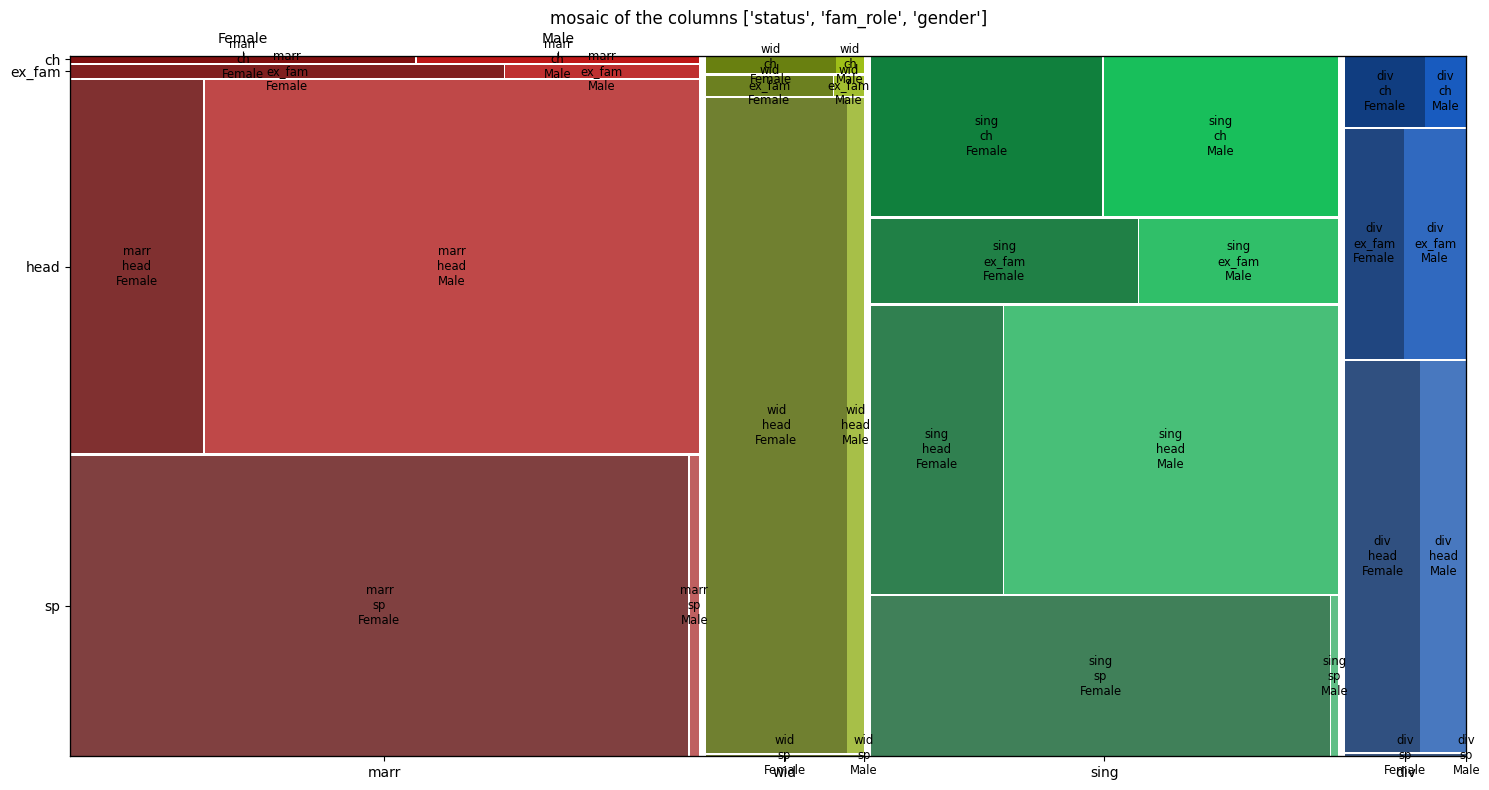

In [255]:
# let's use it on the first set of columns
from statsmodels.graphics.mosaicplot import mosaic


plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["figure.autolayout"] = True


filter_data = df[cols_1]
mosaic(filter_data, index=sorted(cols_1, reverse=True, key=lambda x: len(filter_data[x].value_counts())), title = f'mosaic of the columns {cols_1}')
plt.show()

* let's a make a couple of additional modifications to the values
* as the data groups married and non-married but living together couples, The sing and Spouse: if they are a spouse, they are married
* if an individual is widowed or married, then they can't be a spouse
* let's assume we are in a perfect world, where a child can only be single (mainly neither divorced, widowed nor married)
* it is interesting to consider the rows with married women as leader of the household

In [256]:
# let's apply these modifications
def family_situation(row):
    # if they are a spouse, then they are married
    if row['fam_role'] == 'sp':
        row['status'] = 'marr'
    # if they a child then they are single:
    if row['fam_role'] == 'ch':
        row['status'] = 'sing'
    # if they are widowed
    if row['status'] in ['wid', 'div'] and row['fam_role'] == 'sp':
        row['fam_role'] = 'head'

    return row
 
df, df_test = apply_functions(df, df_test, family_situation)

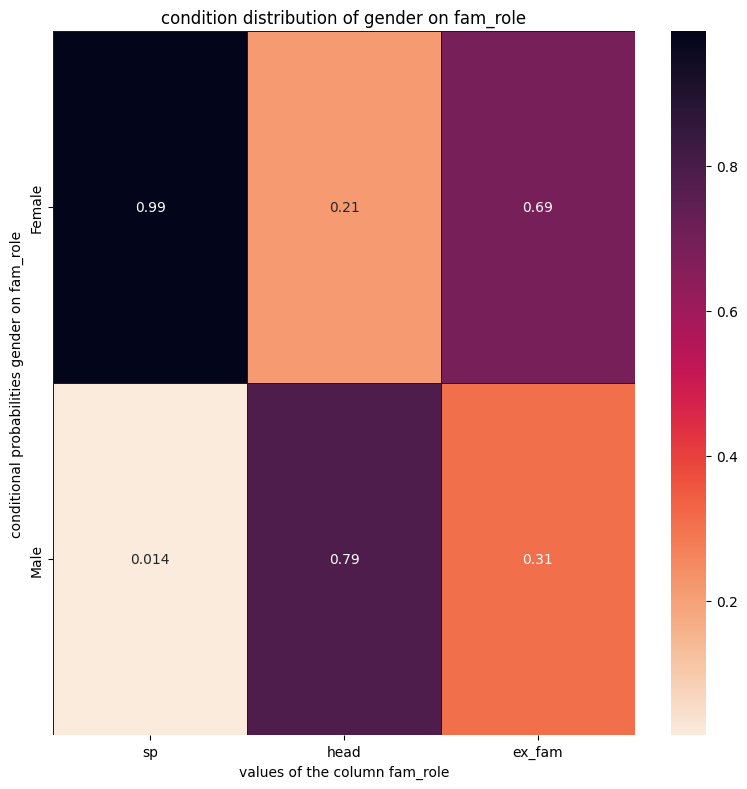

In [257]:
# the visualization of the conditional distribution showed that only the head has a significant difference than the other fam_role values.
# let's see what affects the head of the house hold owning a bank account
# the main factors (hypothetically) are education level, job and gender

plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True

married = df[df['status'] == 'marr']

visualize_cond_prob(married, target='gender', hue='fam_role')

# head_data = df[(df['fam_role'] == 'head') & (df['status'] == 'marr')]

# cols2 = ['job', 'edu', 'gender', 'status']
# for c in cols2:        
#     visualize_cond_prob(head_data, target='y', hue=c) 

married_head = married[married['fam_role'] == 'head']


In [258]:
df, df_test = drop_cols('gender', df, df_test)

In [259]:
# time to convert the status to a numerical value
status_fam_role = pd.pivot_table(df, values='y', columns='fam_role', index='status').round(2)
print(status_fam_role)

status = list(status_fam_role.index)
num_status = status_fam_role['head'].tolist()
status_dict = dict(zip(status, num_status))

df, df_test = map_values(df, df_test, columns='status', cols_dicts=status_dict)

fam_role    ch  ex_fam  head    sp
status                            
div        NaN    0.05  0.16   NaN
marr       NaN    0.09  0.21  0.11
sing      0.09    0.10  0.19   NaN
wid        NaN    0.06  0.09   NaN


## family role, education and job

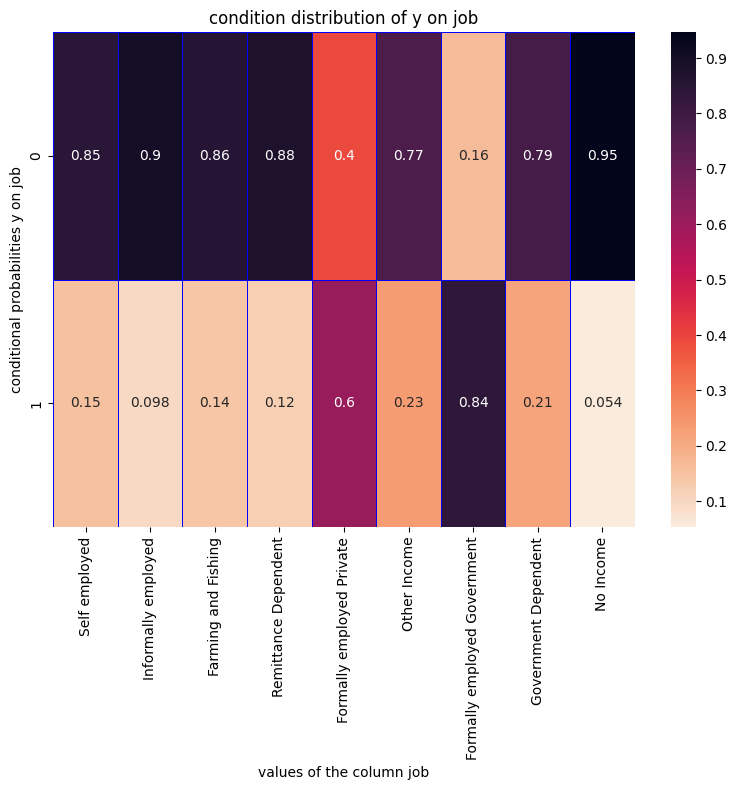

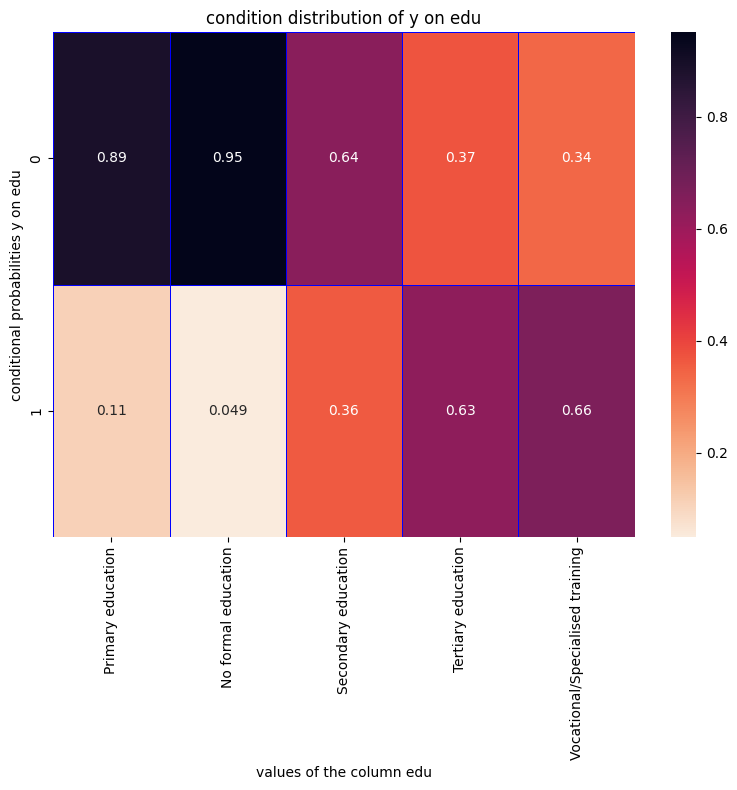

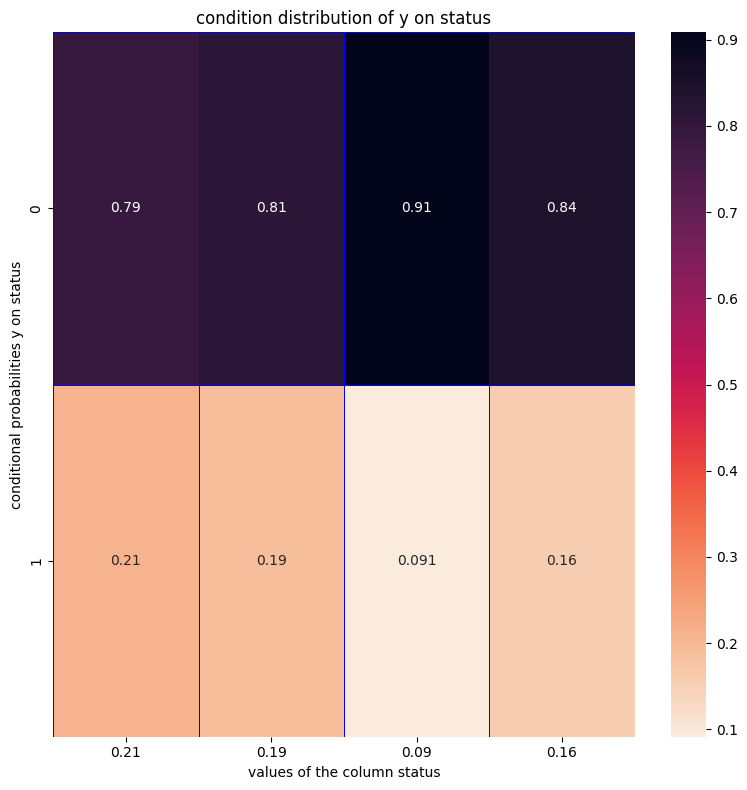

In [260]:
# let's see how heads are impacted by other factors
head_data = df[(df['fam_role'] == 'head')]

cols2 = ['job', 'edu', 'status']
for c in cols2:       
    visualize_cond_prob(head_data, target='y', hue=c) 



In [261]:
print(df['edu'].value_counts())
print(df['job'].value_counts())

Primary education                  12791
No formal education                 4550
Secondary education                 4223
Tertiary education                  1157
Vocational/Specialised training      803
Name: edu, dtype: int64
Self employed                   6437
Informally employed             5597
Farming and Fishing             5441
Remittance Dependent            2527
Other Income                    1080
Formally employed Private       1055
No Income                        753
Formally employed Government     387
Government Dependent             247
Name: job, dtype: int64


In [262]:
# the main idea is to group tertiary education + training, primary education + no education, and then secondary education
group_edu = {"No formal education": 0, "Primary education": 0, "Secondary education": 1, "Tertiary education": 2, "Vocational/Specialised training": 2}
group_job = {"Formally employed Government":3, "Formally employed Private": 2
, "Other Income": 1, "Government Dependent": 1}

df, df_test = map_values(df, df_test, ['edu', 'job'], [group_edu, group_job])

# let's map the rest of the job values
def map_rest_job(row):
    if not isinstance(row['job'], int):
        row['job'] = 0
    return row

df, df_test = apply_functions(df, df_test, map_rest_job)

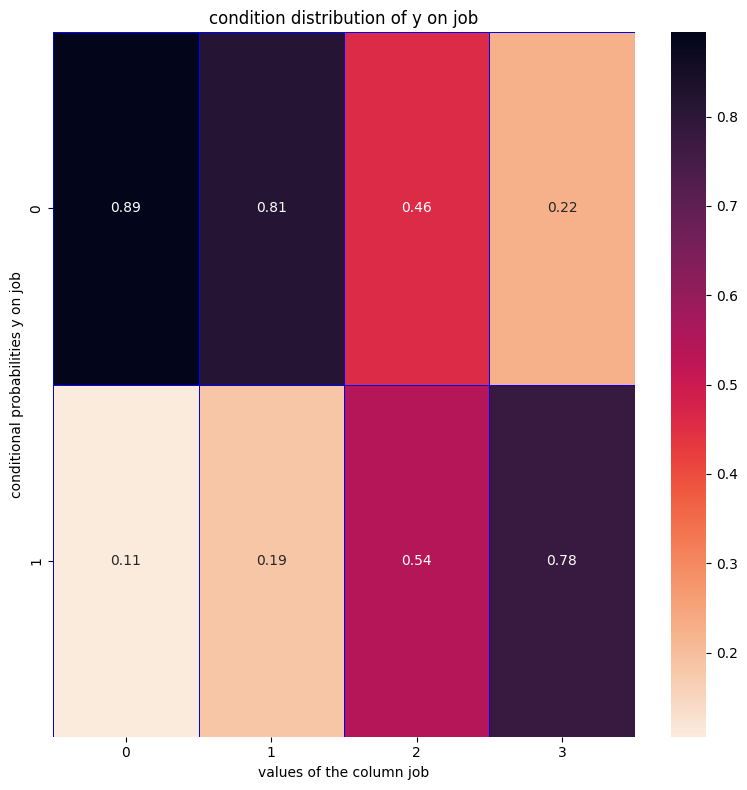

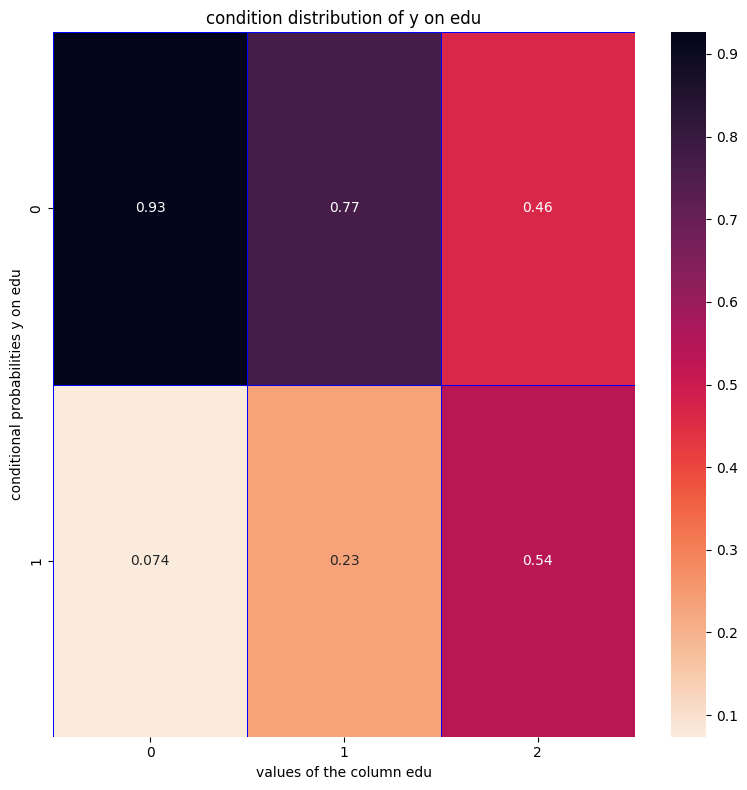

In [263]:
visualize_cond_prob(df, 'y', 'job')
visualize_cond_prob(df, 'y', 'edu')
# we can see that the new grouping is notably more informative

* let's recap really quick: so here is what the data says: The most important member of the family (in the context of classification of course) is the ***head***. If the head does not have a bank account, then none of the family members do. What affects the head's probability of having a bank account is mainly the educational level and the job type. 
* To bridge the gap between the head and the rest of the rest of the family members, it might be possibly to inspect the ids and try to group the rows by family (which may or may not be possible). However, for a baseline we can consider the common feature which is the size of the household.

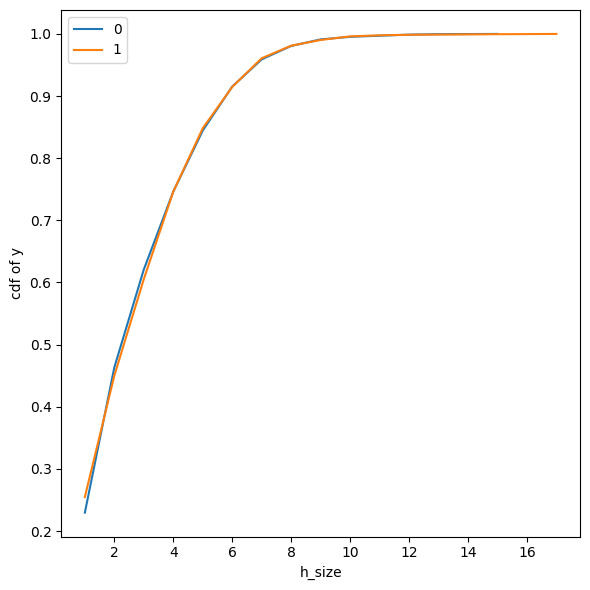

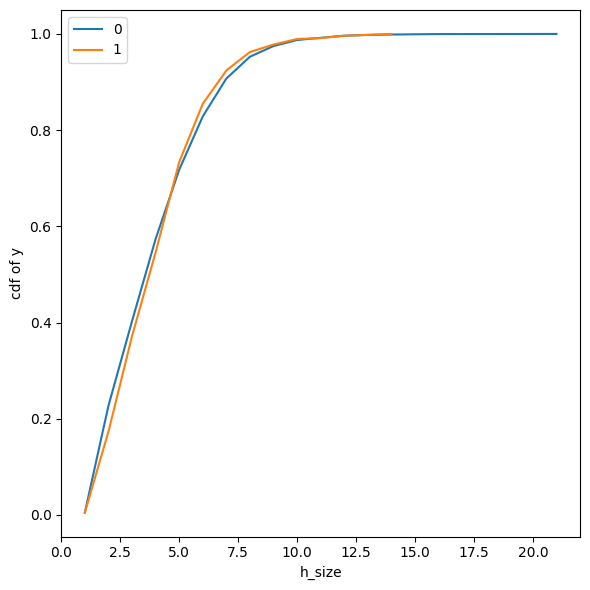

In [264]:
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

# first for heads of families
heads = df[df['fam_role'] == 'head']
visualize_num_cat(heads, num_feat='h_size', cat_feat='y', num_cat='cdf', nunique_as_discrete=15)
# well it seems that the size of the house hold does not seem to differ much
# let's see for the non-head family members
non_heads = df[df['fam_role'] != 'head']
visualize_num_cat(non_heads, num_feat='h_size', cat_feat='y', num_cat='cdf', nunique_as_discrete=15)


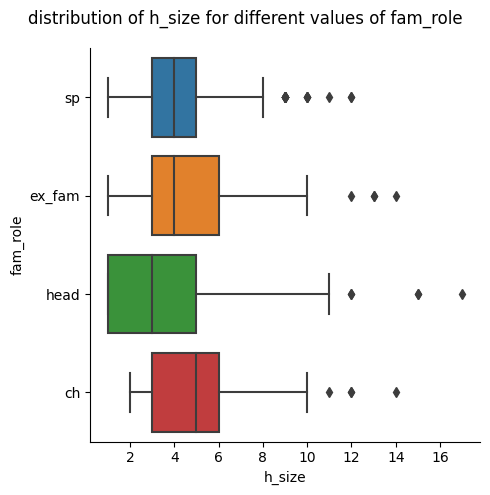

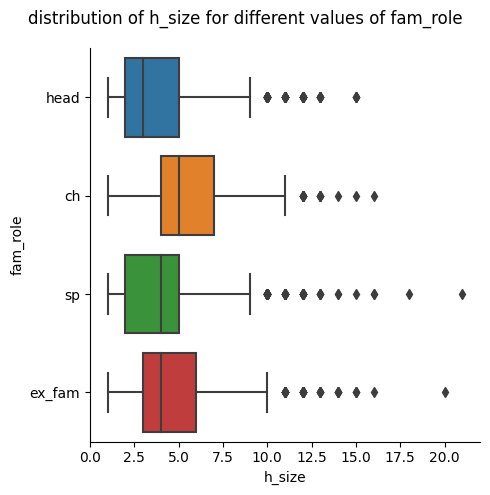

In [265]:
# let's consider it a bit differently now
y1 = df[df['y'] == 1]
y0 = df[df['y'] == 0]
# let's see how the size of the house hold different according to the family role in each of these tables
visualize_num_cat(y1, num_feat='h_size', cat_feat='fam_role', nunique_as_discrete=15, num_cat='box')
visualize_num_cat(y0, num_feat='h_size', cat_feat='fam_role', nunique_as_discrete=15, num_cat='box')

In [266]:
# let's have these values displayed numerically
fam_size_role = pd.pivot_table(df, values='h_size', index='y', columns='fam_role', aggfunc=['max', 'min', 'median', 'mean', lambda x: np.percentile(x, 75, interpolation='midpoint')])
# the difference between the families with a bank account and those without lies mainly in the 
fam_size_role = fam_size_role.rename(columns={"<lambda>": 'q3'})
print(fam_size_role)

# one possible way to is to divide the size of the household on the maximum house hold in families with bank accounts according to the family role.
def set_house_hold(row):
    row['role_size_ratio'] = row['h_size'] / (fam_size_role.loc[1, ('q3', row['fam_role'])])
    return row

df, df_test = apply_functions(df, df_test, set_house_hold)

# according to this table, the family roles can be ordered as follows:
# head, spouse, ex_fam, child
fam_role_map = {"head": 4, "sp":3, "ex_fam": 2, "ch": 1}
df, df_test = map_values(df, df_test, columns=['fam_role'], cols_dicts=fam_role_map)

# let's remove the house-hold-size
df, df_test = drop_cols('h_size', df, df_test)

         max                 min                median                 \
fam_role  ch ex_fam head  sp  ch ex_fam head sp     ch ex_fam head sp   
y                                                                       
0         16     20   15  21   1      1    1  1      5      4    3  4   
1         14     14   17  12   2      1    1  1      5      4    3  4   

              mean                               q3                 
fam_role        ch    ex_fam      head        sp ch ex_fam head sp  
y                                                                   
0         5.225442  4.464584  3.258572  4.158455  7      6    5  5  
1         4.829016  4.529801  3.259569  4.368345  6      6    5  5  


## Country, Urban or rural ???

Last see if there are any major differences between urban and ural areas in relation to the country column

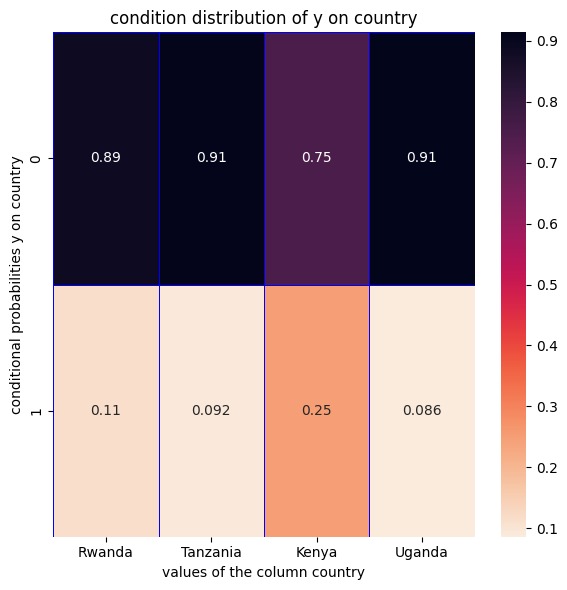

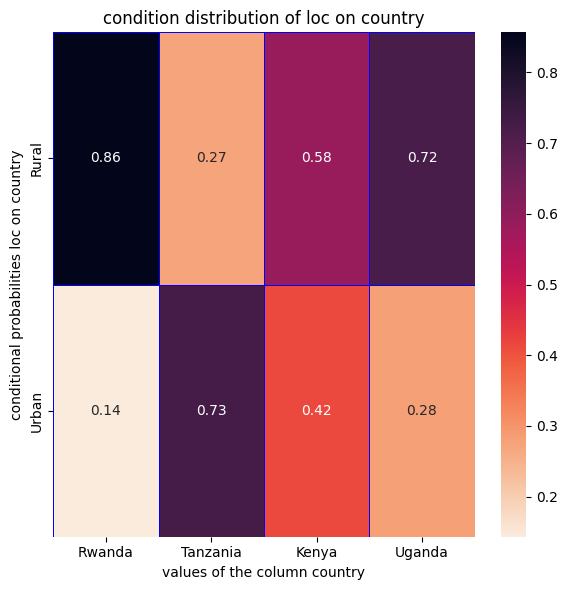

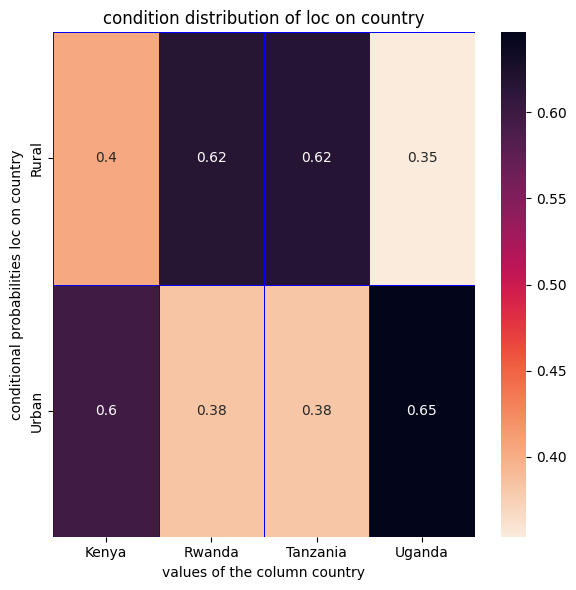

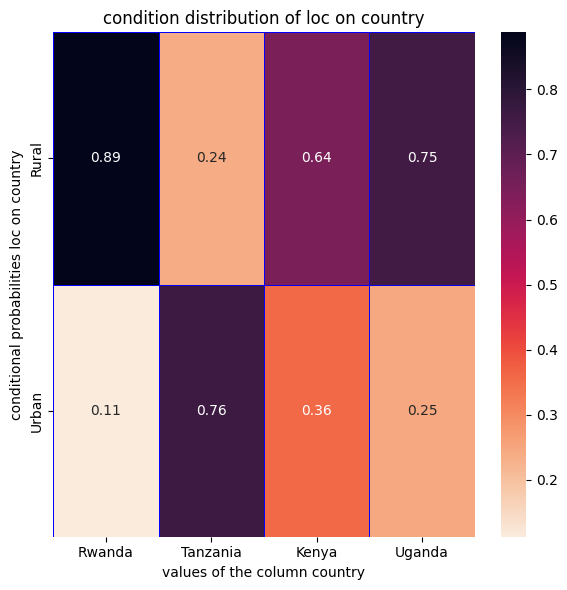

In [267]:
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

visualize_cond_prob(df, target='y', hue='country')
visualize_cond_prob(df, hue='country', target='loc')
# the proportions of urban and rural distributions are quite different depending on the country
visualize_cond_prob(y1, target='loc', hue='country')
visualize_cond_prob(y0, target='loc', hue='country')

In [268]:
# the visualizatinos suggest a different intercation between y and the loc column depending on the country
# let's better demonstrate this with a summarized table
country_loc_df = pd.pivot_table(df, index='country', columns='loc', values='y').round(decimals=2)
print(country_loc_df)
# let's proceed with replacing the two columns by one column demonstrating their combinations  

def country_loc(row):
    row['country_loc'] = country_loc_df.loc[row['country'], row['loc']]
    return row

df, df_test = apply_functions(df, df_test, country_loc)

loc       Rural  Urban
country               
Kenya      0.17   0.36
Rwanda     0.08   0.31
Tanzania   0.21   0.05
Uganda     0.04   0.20


In [269]:
# finally remove the unncessary columns
df, df_test = drop_cols(['country', 'loc'], df, df_test)

In [270]:
# let's just encode the phone really quick
df['phone'] = df['phone'].str.lower()
df_test['phone'] = df_test['phone'].str.lower()

phone_dict = {"yes": 1, "no": 0}

df, df_test = map_values(df, df_test, columns='phone', cols_dicts=phone_dict)

print("IS ALL OUR DATA NUMERICAL ???")
print(df.head(20))

print("DID WE GET RID OF ALL NULL VALUES???")
print(df.isna().sum().sum())
print(df_test.isna().sum().sum())

IS ALL OUR DATA NUMERICAL ???
    y  phone  age  fam_role  status  edu  job  role_size_ratio  country_loc
0   1      1   24         3    0.21    1    0         0.600000         0.17
1   0      0   70         4    0.09    0    1         1.000000         0.17
2   1      1   26         2    0.19    2    0         0.833333         0.36
3   0      1   34         4    0.21    0    2         1.000000         0.17
4   0      0   26         1    0.19    0    0         1.333333         0.36
5   0      0   26         3    0.21    0    0         1.400000         0.17
6   0      1   32         3    0.21    0    0         1.400000         0.17
7   0      1   42         4    0.21    2    3         0.200000         0.17
8   1      1   54         4    0.21    1    0         0.600000         0.17
9   0      1   76         4    0.16    0    0         0.600000         0.36
10  0      1   40         4    0.21    1    0         1.000000         0.17
11  1      1   69         4    0.21    1    1         0.60

## first model
In the first iteration we consider a simple Logistic Regression model to have an initial understanding of the complexity of the problem


In [271]:
# first let's pop out the target column from the training dataset
y = df.pop('y')
# then let's apply standard Scaler to the age column
from sklearn.preprocessing import StandardScaler

s = StandardScaler()

df[['age']] = s.fit_transform(df[['age']])

df_test[['age']] = s.transform(df_test[['age']])


In [272]:
from classifiers import tune_model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000)

grid= {"C":np.logspace(-3, 3, 20)}

lr = tune_model(lr, grid, df, y)


<module 'matplotlib.pyplot' from 'c:\\Users\\bouab\\DEV\\ds_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

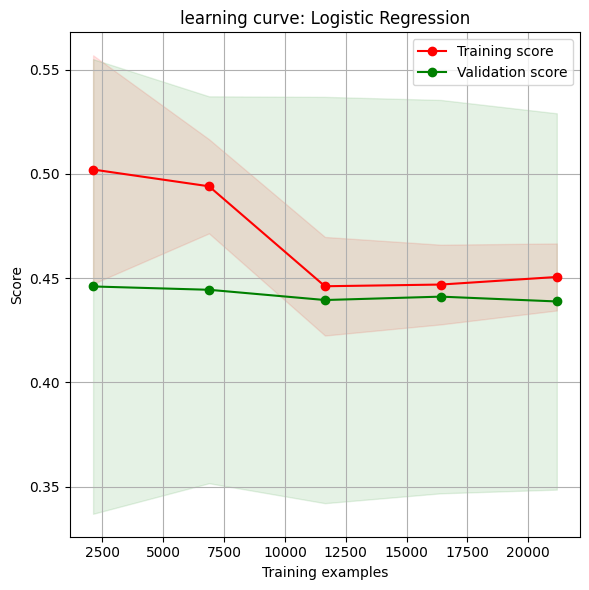

In [276]:
title = "learning curve: Logistic Regression"
cv = 10
plot_learning_curve(lr, title, df, y, cv=cv,n_jobs=-1)

In [278]:
print(len(df_test) == len(initial_df_test))

True


In [283]:
# even though it is clear that Logistic Regression is underfitting the classification problem
# let's test it on the platfor
create_submission(lr, df, y, df_test, "Logistic Regression")


,bank_account
uniqueid,
uniqueid_6056 x Kenya,1
uniqueid_6060 x Kenya,1
uniqueid_6065 x Kenya,0
uniqueid_6072 x Kenya,0
uniqueid_6073 x Kenya,0
...,...
uniqueid_2998 x Uganda,0
uniqueid_2999 x Uganda,0
uniqueid_3000 x Uganda,0
